In [38]:
'''
@author     : Ali Mustofa HALOTEC
@module     : OCR Container Number
@Created on : 29 April 2021
'''

import cv2
import torch
import easyocr
from PIL import Image, ImageDraw
from config_ocr import ConfigOcr

In [41]:
class OpticalCharacterRecognition:
    '''
    Setup configuration EasyOCR
    '''
    def __init__(self):
        self.device = True if torch.cuda.is_available() else False
        self.list_langs = ['en', 'id']
        self.recog_network = 'english_g2'
        self.reader = easyocr.Reader(self.list_langs, gpu=self.device, recog_network=self.recog_network)

    def detect_char(self, image):
        '''
        Detection character in image
        '''
        return self.reader.detect(image)

    def ocr_image(self, image, config):
        '''
        Read text in image with library easy ocr
        with configuration in param config
        '''
        results = self.reader.readtext(
            image,
            detail          = config.detail,
            decoder         = config.decoder,
            beamWidth       = config.beam_width,
            batch_size      = config.batch_size,
            workers         = config.workers,
            allowlist       = config.allow_list,
            blocklist       = config.blocklist,
            paragraph       = config.paragraph,
            min_size        = config.min_size,
            rotation_info   = config.rotation_info,
            # Contrast
            contrast_ths    = config.contrast_ths,
            adjust_contrast = config.adjust_contrast,
            # Text detection
            text_threshold  = config.text_threshold + 0.1 if self.device else config.text_threshold,
            low_text        = config.low_text,
            link_threshold  = config.link_threshold,
            canvas_size     = config.canvas_size,
            mag_ratio       = config.mag_ratio
        )
        return results
    
    def draw_boxes(self, image, bounds, color='yellow', width=2):
        text = []
        confidence = []
        image = Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(image)

        for bound in bounds:
            if bound[2] > 0.0:
                confidence.append(bound[2])
                text.append(bound[1])
                p0, p1, p2, p3 = bound[0]
                draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
        
        # Calculate AVG confidence level
        avgConf = sum(confidence)/len(confidence)
        return image, text, avgConf
            

In [67]:
def resize(image):
    scale_percent = 180
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [43]:
# call class OpticalCharacterRecognition

ocr = OpticalCharacterRecognition()

Using CPU. Note: This module is much faster with a GPU.


In [68]:
image_crop = cv2.imread('result.jpg')
# set size image
image_crop = resize(image_crop) if image_crop.shape[1] <= 175 else image_crop 
print(image_crop.shape[1])
# detec character  
detected_char = ocr.detect_char(image_crop)
image_ocr = image_crop if detected_char else None

205


In [69]:
'''
Set methods and value config ocr
methods view schema/config_ocr.py
'''
config = ConfigOcr(
    beam_width = 20,
    batch_size = 10,
    text_threshold = 0.4,
    link_threshold = 0.7,
    low_text = 0.4,
    slope_ths = 0.9,
)
results_ocr = ocr.ocr_image(image=image_ocr, config=config)
print(results_ocr)

[([[161, 25], [179, 25], [179, 55], [161, 55]], '5', 0.9027947881100005), ([[89, 73], [141, 73], [141, 117], [89, 117]], '2261', 0.9720310675079903), ([[79.17157287525382, 47.17157287525381], [161.13713251847548, 26.518387709265667], [169.82842712474618, 62.82842712474619], [87.86286748152452, 84.48161229073433]], '228446 ', 0.6924174831656966), ([[12.88000423998728, 68.60800678397965], [72.79785219027252, 54.14132493602591], [80.11999576001271, 91.39199321602035], [21.202147809727485, 106.85867506397409]], 'DRYU', 0.9844669103622437)]


In [70]:
image, text, confidence = ocr.draw_boxes(image_ocr, results_ocr)
print(text, confidence)

['5', '2261', '228446 ', 'DRYU'] 0.8879275622864827


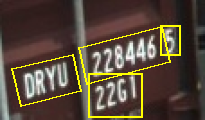

In [71]:
image

In [72]:
def filter_text_conf(text_conf):
    '''
    Remove space in list text_conf and add create new list
    '''
    new_text_conf = list()
    for text, conf in text_conf:
        remove_space = text.split(' ')
        for word in remove_space:
            if word.isalnum():
                new_text_conf.append([word, conf])
    return new_text_conf

results_ocr.sort(reverse=False)
text_conf_list  = [[i[1], i[2]] for i in results_ocr]
filter_text_conf(text_conf_list)

[['DRYU', 0.9844669103622437],
 ['228446', 0.6924174831656966],
 ['2261', 0.9720310675079903],
 ['5', 0.9027947881100005]]